# <center> **Autoencoders**

**Sources** : [Encoder_ressources_Bertrand.pdf](Encoder_ressources.pdf)<br>

https://machinelearningmastery.com/lstm-autoencoders/<br>
https://medium.com/towards-data-science/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352<br>
https://bobrupakroy.medium.com/lstm-autoencoders-a45a04667346<br>
https://www.datacamp.com/fr/tutorial/introduction-to-autoencoders<br>
<br>

Les modèles **Autoencodeurs** peuvent servir de méthodes de réduction de dimensions non linéaires (de type t-SNE ...).<br>

**Encodeur**<br>
La partie encodeur comprime les données d'entrées pour éliminer toute forme de bruit et génère un **espace latent**, sa dimension est un hyper-paramètre qui détermine le niveau de perte de la "compression".

**Décodeur**<br>
Il tente de reconstruire les données d'entrée originales en utilisant uniquement la représentation comprimée des données de l'espace latent, on estime la qualité du modèle en calculant l'erreur de reconstruction à l'aide d'une fonction de perte.

Différents types d'autoencodeurs : (incomplet, clairsemé, contractuel, convolutif, variationnel [source](https://www.datacamp.com/fr/tutorial/introduction-to-autoencoders))<br>

**VAE**<br>
Dans tous les autoencodeurs précédents, le codeur fournit une seule valeur pour chaque dimension. Les **VAE** rendent ce processus probabiliste en créant une distribution de probabilité pour chaque dimension. Application pour des tâches génératives.

## **Imports**

In [72]:
%reset

In [79]:
import os
import cv2
import PIL
import math
import script # my tools
import itertools
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
from numpy import array

# Scipy
from scipy import stats
from scipy.fftpack import fft, ifft
from scipy.stats import kruskal

# Scikit-Learn
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

# statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose

# Keras
from keras.models import Model, Sequential
from keras.layers import LSTM, Input, Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Path of the video
video_path = "videos/seq_a.mov"

video_folder = "videos\\"
video_name = "seq_a.mov"
# video_name = "seq_b.mov"
# video_name = "seq_tractions.mov"
# video_name = "seq_multi_exos.mov"

frame_reps_file_name = 'frame_reps_' + video_name[:-4] + '.npy'
landmarks_file_name  = 'landmarks_' + video_name[:-4]  + '.csv'

## **First Autoencoder**

https://bobrupakroy.medium.com/lstm-autoencoders-a45a04667346

In [ ]:
#define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
#reshape input into [samples, timesteps, features]
n_in = len(sequence) #i.e. 9
sequence = sequence.reshape((1, n_in, 1))
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in, 1)))
model.add(RepeatVector(n_in))

#RepeatVector layer repeats the incoming inputs a specific number of time
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
''' #This wrapper allows to apply a layer to every temporal slice of an input. '''

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 9, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 9, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 9, 1)           │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse')
#fit model
model.fit(sequence, sequence, epochs=300, verbose=1)
#Reconstruct the input sequence
p = model.predict(sequence, verbose=0)
print(p[0,:,0])

## **Autoencoders to count repetitions in a video**

### **Data Process**

**Read the landmarks from csv**

In [75]:
landmarks_file_name = 'landmarks_' + video_name[:-4] + '.csv'

def get_landmarks_from_file(file_name):
    if file_name in os.listdir(video_folder):
        file_path = 'videos/' + landmarks_file_name
        print(f'Read file with the landmarks: {file_path}')
        return pd.read_csv(file_path, sep = ',')

df_landmarks = get_landmarks_from_file(video_name)
df_landmarks

Read file with the landmarks: videos/landmarks_seq_a.csv


,frame_number,landmark_id,x,y,z
0,0,NOSE,0.532603,0.036498,-0.475452
1,0,LEFT_EYE_INNER,0.536636,0.015176,-0.484939
2,0,LEFT_EYE,0.541239,0.014851,-0.484937
3,0,LEFT_EYE_OUTER,0.545789,0.014627,-0.485146
4,0,RIGHT_EYE_INNER,0.529450,0.017664,-0.458892
...,...,...,...,...,...
16495,499,RIGHT_ANKLE,0.601915,0.668691,0.120303
16496,499,LEFT_HEEL,0.665266,0.649924,0.067565
16497,499,RIGHT_HEEL,0.609263,0.628062,0.165659
16498,499,LEFT_FOOT_INDEX,0.698478,0.700875,0.135502


**keep only a few landmarks**

In [76]:
landmarks_to_keep = ['LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW',
                     'LEFT_WRIST','RIGHT_WRIST', 'LEFT_INDEX', 'RIGHT_INDEX', 'LEFT_HIP', 'RIGHT_HIP',
                     'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL', 'NOSE']
landmarks_to_keep.sort()

df_19 = df_landmarks[df_landmarks['landmark_id'].isin(landmarks_to_keep)]
df_19 = df_19.sort_values(by = ['frame_number', 'landmark_id'])
print(df_19.shape)
df_19

(9500, 5)


,frame_number,landmark_id,x,y,z
27,0,LEFT_ANKLE,0.675630,0.646708,0.278460
13,0,LEFT_ELBOW,0.681807,0.313912,-0.441911
31,0,LEFT_FOOT_INDEX,0.706243,0.702106,0.368447
29,0,LEFT_HEEL,0.680110,0.612660,0.333385
23,0,LEFT_HIP,0.610198,0.417119,-0.082105
...,...,...,...,...,...
16491,499,RIGHT_HIP,0.578911,0.583835,0.055039
16487,499,RIGHT_INDEX,0.526342,0.648584,-0.256622
16493,499,RIGHT_KNEE,0.508986,0.724994,-0.287362
16479,499,RIGHT_SHOULDER,0.556983,0.252275,-0.077611


**Create Input tensor**

In [77]:
window_size  = 50
nb_landmarks = len(landmarks_to_keep)
nb_frames    = df_19.shape[0] // nb_landmarks
nb_sequences = nb_frames - window_size + 1
nb_features   = 3 * nb_landmarks

print('window size:\t', window_size)
print('nb landmarks:\t', nb_landmarks)
print('nb frames:\t', nb_frames)
print('nb sequences:\t', nb_sequences)
print('nb features:\t', nb_features)

# Fill in array with coordinates.
X = np.zeros(shape = (nb_sequences, window_size, nb_features))

for i in range(451):
    start  =  nb_landmarks * i
    stop   =  start + nb_landmarks * window_size
    X[i]   =  df_19[start:stop][['x', 'y', 'z']].values.reshape((window_size, nb_features))

print("\narray shape", X.shape)

window size:	 50
nb landmarks:	 19
nb frames:	 500
nb sequences:	 451
nb features:	 57

array shape (451, 50, 57)


**Create Autoencoder**

In [ ]:
from keras import Input, Model

data_shape = X.shape
print("\narray shape", X.shape)

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(X.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(X.shape[2])))
model.compile(optimizer='adam', loss='mse')
model.summary()

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, X, epochs=30, verbose=1)

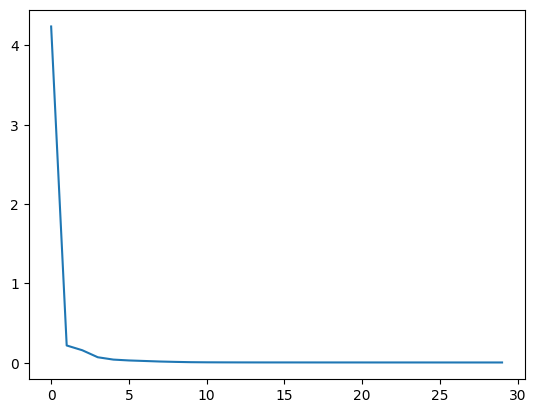

In [71]:
plt.plot(history.history['loss'])
plt.show()

**Ca fonctionne mais on veut séparer la partie encodeur et la partie décodeur**

In [ ]:
latent_dim = 32

# Encoder
inputs = Input(shape=(window_size, nb_features), name = "input_encoder")
encoded = LSTM(latent_dim, activation="relu", return_sequences = False, name = "lstm_encoder")(inputs)

model_encoder = Model(inputs, encoded, name = "encoder_before_training")
model_encoder.summary()

# Decoder
layer1 = RepeatVector(window_size)(encoded)
layer2 = LSTM(32, activation = "relu", return_sequences = True, name="lstm_decoder" )(layer1)
layer3 = TimeDistributed(Dense(nb_features))

model_decoder = Model(layer1, layer2, layer3, name = 'decoder')
model_decoder.summary()

model_autoencoder = Model(inputs, encoded, layer1, layer2, layer3)
model_autoencoder.summary()

Model: "encoder_before_training"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_encoder (InputLayer)      │ (None, 50, 57)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_encoder (LSTM)             │ (None, 32)             │        11,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,520 (45.00 KB)

 Trainable params: 11,520 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

TypeError: Layer.__init__() takes 1 positional argument but 4 positional arguments (and 1 keyword-only argument) were given

In [ ]:
latent_dim = 32

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in, 1)))
model.add(RepeatVector(latent_dim))
#RepeatVector layer repeats the incoming inputs a specific number of time

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1))) # This wrapper allows to apply a layer to every temporal slice of an input.
model.compile(optimizer='adam', loss='mse')

#fit model
model.fit(X, X, epochs=30, verbose=1)

In [ ]:
#define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

#reshape input into [samples, timesteps, features]
n_in = len(sequence) #i.e. 9
sequence = sequence.reshape((1, n_in, 1))

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
#RepeatVector layer repeats the incoming inputs a specific number of time

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1))) # This wrapper allows to apply a layer to every temporal slice of an input.
model.compile(optimizer='adam', loss='mse')

#fit model
model.fit(sequence, sequence, epochs=300, verbose=1)

#Reconstruct the input sequence
p = model.predict(sequence, verbose=0)
print(p[0,:,0])

**Encodeur Code Bertrand**

In [ ]:
# Encodeur
inputs = Input(shape=(seq_length, n_features), name="input_encoder")
encoded = LSTM(latent_dim, activation="relu", return_sequences=False, name="lstm_encoder")(inputs)

model_encoder = Model(inputs, encoded, name="encoder_before_training")

layer1 = RepeatVector(seq_length)(encoded)
layer2 = LSTM(32,activation="relu", return_sequences=True, name="lstm_decoder" )(layer1)
layer3 = model.add(TimeDistributed(Dense(nb_features)))

model_decoder = Model(layer1, layer2, name = 'ff')